In [0]:
! pip install kaggle


In [0]:
! mkdir -p ~/.kaggle/
! pwd
! mv kaggle.json ~/.kaggle/

/content


In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
path = Config.data_path()/'retinaImages'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/retinaImages')

In [0]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 8.00G/8.01G [01:49<00:00, 86.3MB/s]
100% 8.01G/8.01G [01:49<00:00, 78.3MB/s]
 99% 1.49G/1.50G [00:36<00:00, 59.0MB/s]
100% 1.50G/1.50G [00:36<00:00, 43.7MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 31.7MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 23.4MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 50.4MB/s]


In [0]:
! mv sample_submission.csv {path}/
! mv test.csv {path}/
! mv test_images.zip {path}/
! mv train.csv {path}/
! mv train_images.zip {path}/


In [0]:
! unzip -q -n {path}/train_images.zip -d {path}/train_images

In [0]:
! unzip -q -n {path}/test_images.zip -d {path}/test_images

In [0]:
df_train = pd.read_csv(path/'train.csv')
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [32]:
df_test = pd.read_csv(path/'test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [0]:
#data label counts
#df.columns

#df_.shape
df_train['diagnosis'].value_counts()


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

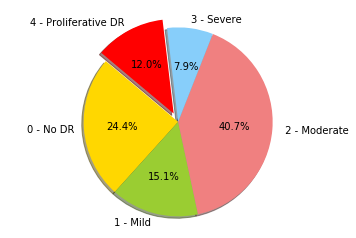

In [0]:
#exploratory analysis


import matplotlib.pyplot as plt
 
# Data to plot
labels = '0 - No DR', '1 - Mild', ' 2 - Moderate', '3 - Severe','4 - Proliferative DR'
sizes = [1805, 370, 999, 193,295]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red'] #magenta
explode = (0, 0, 0, 0,0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()


# looking at the data set we know that we have almost 50% NO DR cases , this can lead to an model over fitting and given the imbalance in label samples
# it may not be the best representative data set , but as part of our goal from this capstone , we would like to predict Proliferative DR [lable -4] more 
#accuratley than any other , but given the data challenges we decided to predict No DR case with utmost highest accuracy as possible 


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [31]:
! ls -ltr {path}/

total 9975624
-rw-r--r-- 1 root root 8602001734 Sep  9 13:47 train_images.zip
-rw-r--r-- 1 root root 1612694851 Sep  9 13:48 test_images.zip
-rw-r--r-- 1 root root      54948 Sep  9 13:48 train.csv
-rw-r--r-- 1 root root      25072 Sep  9 13:48 test.csv
-rw-r--r-- 1 root root      28938 Sep  9 13:48 sample_submission.csv
drwxr-xr-x 2 root root      69632 Sep  9 13:52 test_images
drwxr-xr-x 2 root root     135168 Sep  9 13:54 train_images
drwxr-xr-x 2 root root       4096 Sep  9 14:13 models


In [0]:
! ls {path}/train_images/

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='train_images', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df()) #label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
#data classes
#data.c
data.classes
#len(data.classes)

[0, 1, 2, 3, 4]

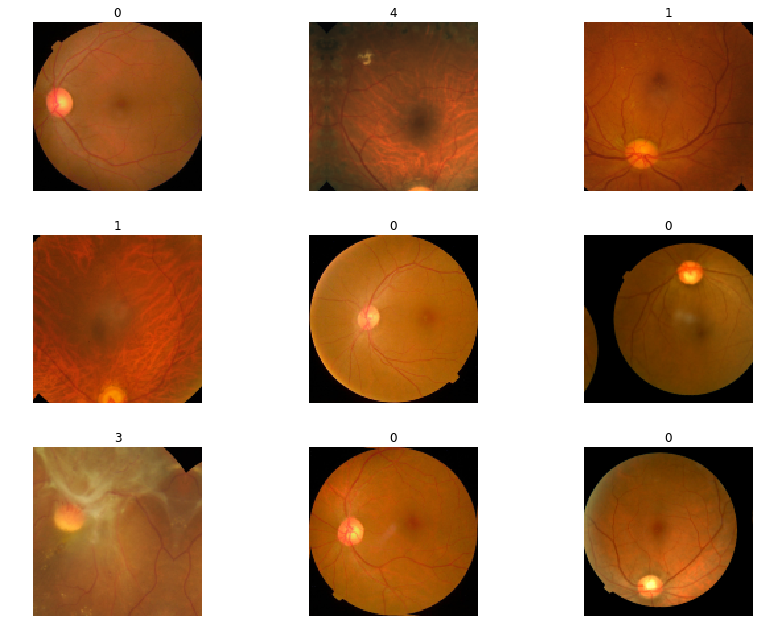

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
def accuracy_01(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    targs = targs.view(-1).long()
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
 

def my_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()#Error from here. Try to correct the conversion for your case

def my_error_rate(input:Tensor, targs:Tensor)->Rank0Tensor:
    "1 - `accuracy`"
    return 1 - my_accuracy(input, targs)
  

#accuracy at threshold of 0.2 , prints accuracy at threshold of 0.2 TODO: check different 0.2 
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
#learn = cnn_learner(data, arch, metrics=[acc_02, f_score],callback_fns=ShowGraph)
#learn = cnn_learner(data, arch, metrics=[error_rate],callback_fns=ShowGraph)
#learn = cnn_learner(data, arch, metrics=[accuracy_01]) #,callback_fns=ShowGraph)
#learn = cnn_learner(data, arch, metrics=[accuracy_thresh])
learn = cnn_learner(data, arch, metrics=[my_error_rate])

In [34]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


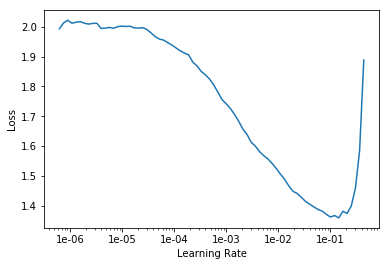

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.02

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,time


RuntimeError: ignored

In [0]:
learn.save('stage-1-rn50')

In [0]:
#algorithm mistakes 
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.most_confused(min_val=2.)


RuntimeError: ignored

Fine Tuning :

In [0]:
learn.unfreeze()

In [0]:
#learn.lr_find()
#learn.recorder.plot()


In [0]:
learn.fit_one_cycle(5, slice(1e-4,1e-3)) #lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.654607,0.494565,0.399454,0.619956,08:16
1,0.506715,0.276120,0.708743,0.781784,08:18
2,0.353571,0.219865,0.865574,0.843539,08:18
3,0.261225,0.189524,0.887705,0.860493,08:22
4,0.213061,0.184695,0.888251,0.858867,08:20


In [0]:
learn.save('stage-2-rn50')

In [0]:
! pwd

/content


In [0]:
#confusion matrix

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
#test data set


preds,y = learn.get_preds(is_test=True)

#When you call get_preds, a sigmoid is applied to your final layer, yes, so that you get the actual predictions.
#So if you apply a metric, you need to use it with sigmoid=False. You can use learn.validate to get the values of the metrics directly.
test = ImageItemList.from_folder(os.path.join(path, 'test_images'))
#learner = load_learner(path, fname='stage-2-rn50', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds